In [1]:
import sys
sys.path.append("asm_full_opt")

from system_psf import SystemPSF
import config
import numpy as np
import matplotlib.pyplot as plt
import torch


In [2]:
system = SystemPSF(config, phase_init="hyperbolic", phase_noise_std=0.0, wrap_phase=False)

psf_stack, meta = system(strategy="block", block_size=4, normalize=True, return_meta=True)
print(psf_stack.shape)   


torch.Size([49, 255, 255])


psf_stack: torch.Size([49, 255, 255])   (P, N, N)
blocks: 7 x 7


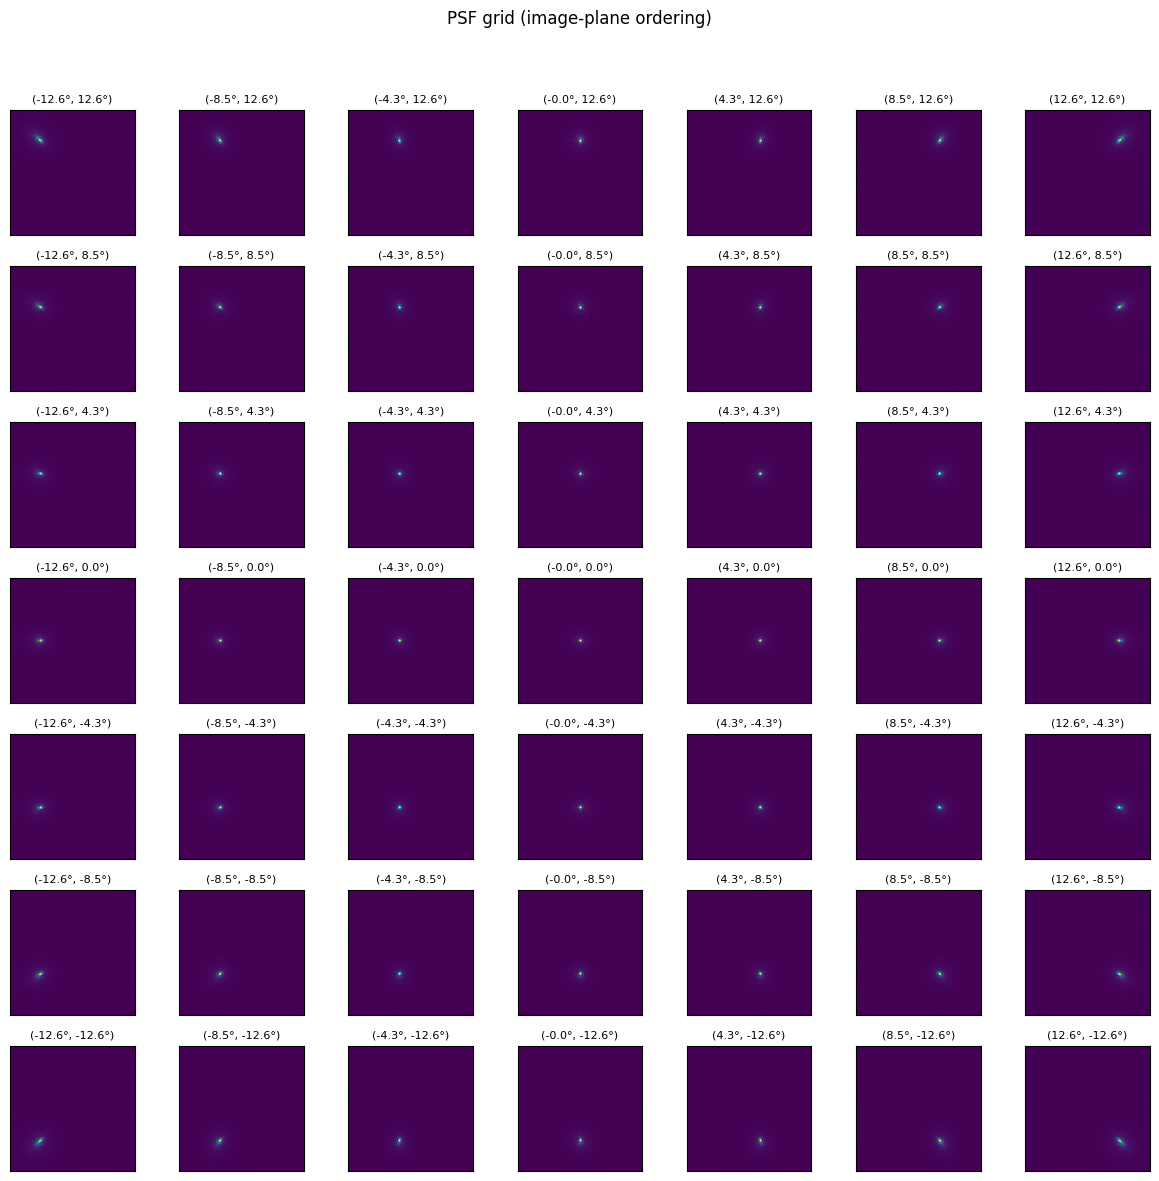

PSF sum stats: 0.9999999 1.0 1.0000001


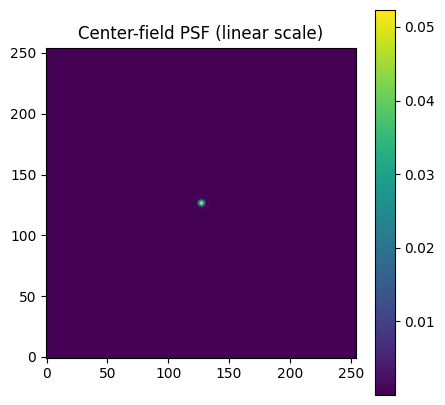

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# --- Unpack ---
P, N, _ = psf_stack.shape
nBW = system.gw.nBW
nBH = system.gw.nBH
print("psf_stack:", psf_stack.shape, "  (P, N, N)")
print("blocks:", nBH, "x", nBW)

# --- 7x7 PSF Grid ---
psf_grid = psf_stack.reshape(nBW, nBH, N, N)

fig, axes = plt.subplots(nBH, nBW, figsize=(12, 12))

for bi in range(nBH):          # block_v (rows)
    for bj in range(nBW):      # block_u (cols)

        # Lens inversion: flip both axes
        bi_img = nBH - 1 - bi
        bj_img = nBW - 1 - bj

        ax = axes[bi_img, bj_img]

        psf = psf_grid[bj, bi].detach().cpu().numpy()
        img = psf**0.5

        ax.imshow(img.T, origin="lower", interpolation="nearest")
        ax.set_xticks([])
        ax.set_yticks([])

        p = bj * nBH + bi
        tx = float(meta["theta_x"][p].detach().cpu().numpy() * 180/np.pi)
        ty = float(meta["theta_y"][p].detach().cpu().numpy() * 180/np.pi)
        ax.set_title(f"({tx:.1f}°, {ty:.1f}°)", fontsize=8)

fig.suptitle("PSF grid (image-plane ordering)", y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# --- Quick sanity checks ---
# 1) each PSF sums to ~1
sums = psf_stack.sum(dim=(-2, -1)).detach().cpu().numpy()
print("PSF sum stats:", sums.min(), sums.mean(), sums.max())

# 2) show center PSF in linear scale
p_center = (nBW // 2) * nBH + (nBH // 2)
plt.figure(figsize=(5, 5))
plt.imshow(psf_stack[p_center].detach().cpu().numpy().T, origin="lower")
plt.title("Center-field PSF (linear scale)")
plt.colorbar()
plt.gca().set_aspect("equal")
plt.show()


Chosen index p = 27
Actual angles (deg): theta_x = -0.0 theta_y = 12.62412
Predicted y shift h = f*tan(theta_y): 22.352648289714907 um


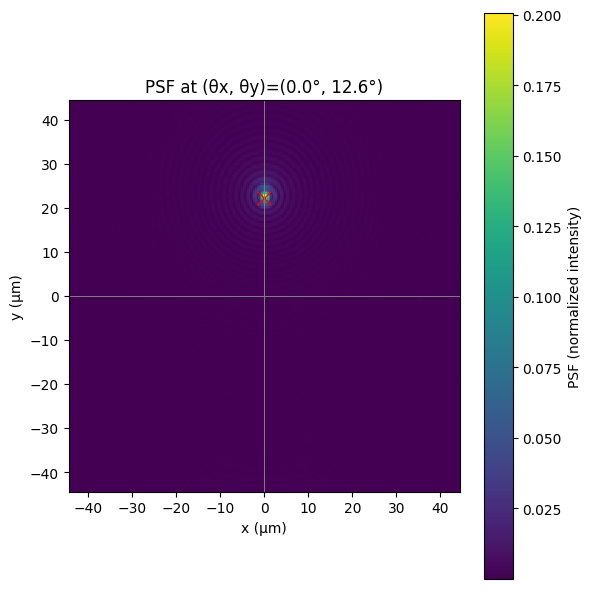

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- pick the target angle (degrees) ---
tx_target = 0.0
ty_target = 12.6

# meta["theta_x"], meta["theta_y"] are radians
tx_deg = meta["theta_x"].detach().cpu().numpy() * 180/np.pi
ty_deg = meta["theta_y"].detach().cpu().numpy() * 180/np.pi

# find closest PSF to (0, 12.6)
p = np.argmin((tx_deg - tx_target)**2 + (ty_deg - ty_target)**2)

print("Chosen index p =", p)
print("Actual angles (deg): theta_x =", tx_deg[p], "theta_y =", ty_deg[p])

# --- compute predicted shift h = f * tan(theta_y) ---
f = float(config.EFL)  # meters
theta_y_rad = math.radians(ty_target)
h_m = f * math.tan(theta_y_rad)
h_um = h_m * 1e6

print("Predicted y shift h = f*tan(theta_y):", h_um, "um")

# --- get spatial extent in um for plotting ---
X = system.gw.X.detach().cpu().numpy()
Y = system.gw.Y.detach().cpu().numpy()

x_um = X[:, 0] * 1e6
y_um = Y[0, :] * 1e6

extent = [x_um.min(), x_um.max(), y_um.min(), y_um.max()]

# --- plot PSF and overlay marker at (x=0, y=h) ---
psf = psf_stack[p].detach().cpu().numpy()

plt.figure(figsize=(6, 6))
plt.imshow((psf**0.5).T, origin="lower", extent=extent, interpolation="nearest")
plt.colorbar(label="PSF (normalized intensity)")
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.title(f"PSF at (θx, θy)=({tx_target}°, {ty_target}°)")

# marker at x=0, y = f*tan(ty_target)
plt.scatter([0.0], [h_um], marker="x", s=100, linewidths=1, color='r')

# axes lines for reference
plt.axhline(0, color="gray", linewidth=0.7)
plt.axvline(0, color="gray", linewidth=0.7)

plt.gca().set_aspect("equal")
plt.tight_layout()
plt.show()


psf_stack: torch.Size([49, 255, 255])   (P, N, N)
blocks: 7 x 7


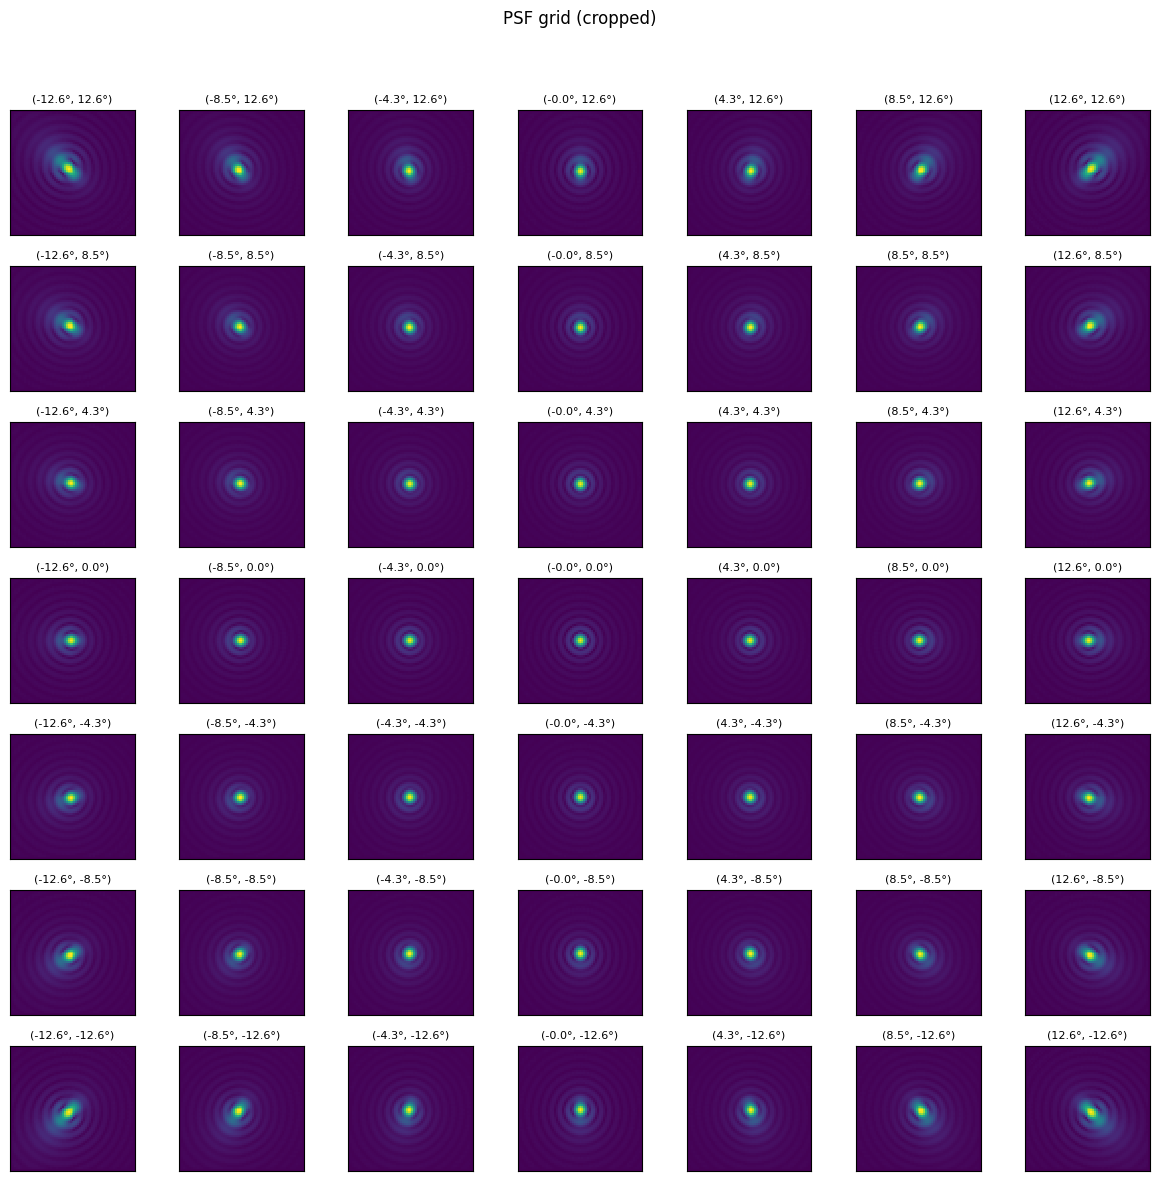

In [5]:
import matplotlib.pyplot as plt
import torch
from psf_preprocess import PSFPreProcessor

# Run preprocessing
pre = PSFPreProcessor(config)
psf_crop = pre(psf_stack, system.pixel_map, system.gw, uv_samples=None, hfov_deg=None)   # [P, Wn, Wn]

P, N, _ = psf_crop.shape
nBW = system.gw.nBW
nBH = system.gw.nBH
print("psf_stack:", psf_stack.shape, "  (P, N, N)")
print("blocks:", nBH, "x", nBW)

# --- 7x7 PSF Grid ---
psf_grid = psf_crop.reshape(nBW, nBH, N, N)

fig, axes = plt.subplots(nBH, nBW, figsize=(12, 12))

for bi in range(nBH):          # block_v (rows)
    for bj in range(nBW):      # block_u (cols)

        # Lens inversion: flip both axes
        bi_img = nBH - 1 - bi
        bj_img = nBW - 1 - bj

        ax = axes[bi_img, bj_img]

        psf = psf_grid[bj, bi].detach().cpu().numpy()
        img = psf**0.5

        ax.imshow(img.T, origin="lower", interpolation="nearest")
        ax.set_xticks([])
        ax.set_yticks([])

        p = bj * nBH + bi
        tx = float(meta["theta_x"][p].detach().cpu().numpy() * 180/np.pi)
        ty = float(meta["theta_y"][p].detach().cpu().numpy() * 180/np.pi)
        ax.set_title(f"({tx:.1f}°, {ty:.1f}°)", fontsize=8)

fig.suptitle("PSF grid (cropped)", y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [6]:
# Check cropped sums
sums = psf_crop.sum(dim=(-2, -1)).detach().cpu().numpy()
print("PSF cropped sum stats:", sums.min(), sums.mean(), sums.max())

PSF cropped sum stats: 0.96925724 0.9736288 0.97585434


In [7]:
x_m, y_m = system.pixel_map.angles_to_sensor_xy(system.gw.theta_x, system.gw.theta_y)

print("First 5 PSF centers (meters):")
for i in range(5):
    print(f"{i:2d}: x = {(x_m[i]*1e6).item(): .3f} um, y = {(y_m[i]*1e6).item(): .3f} um")

print("\nMin / Max:")
print("x:", x_m.min().item(), "→", x_m.max().item())
print("y:", y_m.min().item(), "→", y_m.max().item())


First 5 PSF centers (meters):
 0: x =  22.397 um, y = -22.397 um
 1: x =  22.397 um, y = -14.931 um
 2: x =  22.397 um, y = -7.466 um
 3: x =  22.397 um, y =  0.000 um
 4: x =  22.397 um, y =  7.466 um

Min / Max:
x: -2.239685272797942e-05 → 2.239685272797942e-05
y: -2.239685272797942e-05 → 2.239685272797942e-05
